Install Some Missing Libraries

In [1]:
!pip install yfinance
!pip install pmdarima
!pip install pandas_datareader
!pip install prophet
!pip install XGboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00


In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00


In [4]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################
# stock_data = yf.download('AAPL') # you can choose whatever stockticker you want

# num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

# Here I choose to only use the last 3 years of stock data
# slice = int(len(stock_data)- 356*3)
# stock_data = stock_data.iloc[slice:]

stock_data = pd.read_csv("etf_prices_training_2010-2024.csv")
num_days_pred = 30

# choose an ETF to predict for
stock_data = stock_data[stock_data['ETF'] == 'SPY']

# Here I Choose to continue with only Close value column since that is what we care about
stock_data.drop(columns=['open', 'high', 'low', 'adjclose', 'volume', 'delta_price', 'direction', 'ETF'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'close'
    df['lag1'] = df[target].shift(num_days_pred)
    df['lag2'] = df[target].shift(num_days_pred*2)
    df['lag3'] = df[target].shift(num_days_pred*3)
    df['lag4'] = df[target].shift(num_days_pred*4)
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)
    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    days = []
    months = []
    years = []
    for idx, row in df.iterrows():
      dt = datetime.datetime.strptime(row['formatted_date'], "%Y-%m-%d")
      days.append(dt.day)
      months.append(dt.month)
      years.append(dt.year)
    df['dayofmonth'] = days
    df['month'] = months
    df['year'] = years
    # Drop the formatted date column
    df.drop(columns=['formatted_date'], inplace=True)
    return df

In [ ]:
def create_features_idx(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    days = []
    months = []
    years = []
    for idx, row in df.iterrows():
      dt = datetime.datetime.strptime(str(row['formatted_date']), "%Y-%m-%d %H:%M:%S")
      days.append(dt.day)
      months.append(dt.month)
      years.append(dt.year)
    df['month'] = months
    df['year'] = years
    df['dayofmonth'] = days
    return df

# XGBOOST

In [ ]:
df_xgb = stock_data.copy()

In [ ]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)

    X = df_xgb.drop(columns='close')
    y = df_xgb['close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-28 15:05:40,504] A new study created in memory with name: no-name-beb0fdd3-e46e-412d-9224-1cd3e4bdc97d
[I 2024-04-28 15:05:43,783] Trial 0 finished with value: 6.790566602775108 and parameters: {'n_estimators': 945, 'max_depth': 10, 'learning_rate': 0.07628399886382245, 'subsample': 0.8104403078895119, 'colsample_bytree': 0.6881665771650709, 'reg_alpha': 3.5604861551533573, 'reg_lambda': 8.381738375408428}. Best is trial 0 with value: 6.790566602775108.
[I 2024-04-28 15:05:45,163] Trial 1 finished with value: 6.8084228536993 and parameters: {'n_estimators': 495, 'max_depth': 8, 'learning_rate': 0.024535371319678742, 'subsample': 0.6401222477280618, 'colsample_bytree': 0.6241679766019599, 'reg_alpha': 5.271643552299183, 'reg_lambda': 6.1084821435125205}. Best is trial 0 with value: 6.790566602775108.
[I 2024-04-28 15:05:47,583] Trial 2 finished with value: 7.853022031408952 and parameters: {'n_estimators': 957, 'max_depth': 6, 'learning_rate': 0.0587924764244782, 'subsample':

Best trial:
  Value: 6.4461062610867685
  Params: 
    n_estimators: 851
    max_depth: 7
    learning_rate: 0.07261637806373028
    subsample: 0.9053919617723434
    colsample_bytree: 0.6367112032584349
    reg_alpha: 3.5341207329010835
    reg_lambda: 8.118434522845966
Test RMSE: 6.4461062610867685


## Evaluate

In [ ]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 1.8912090881507582% 


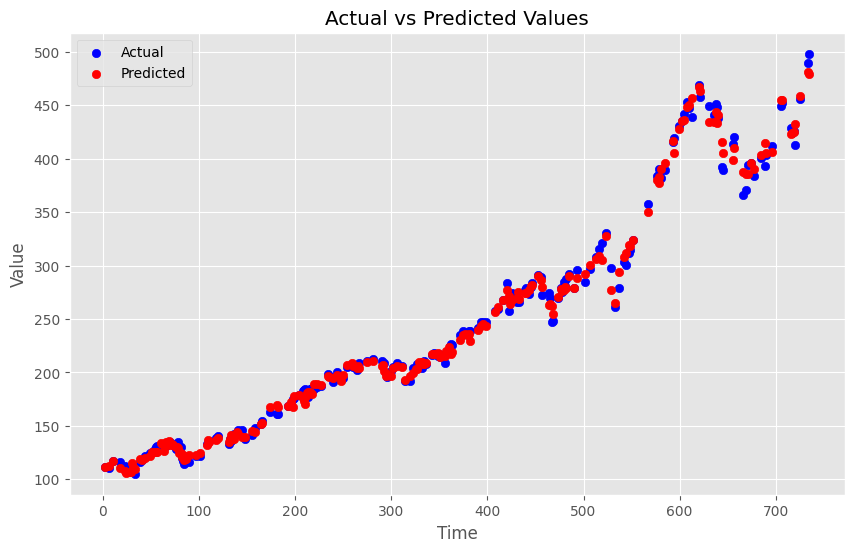

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

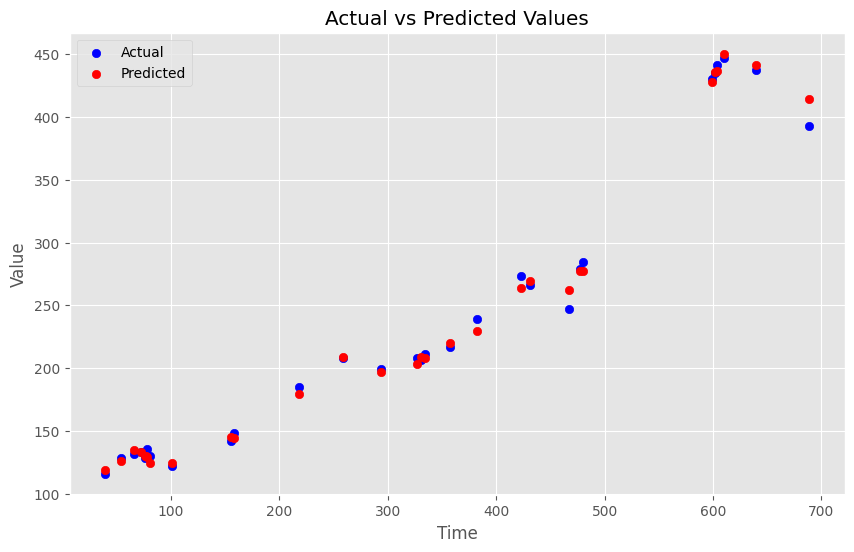

In [ ]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

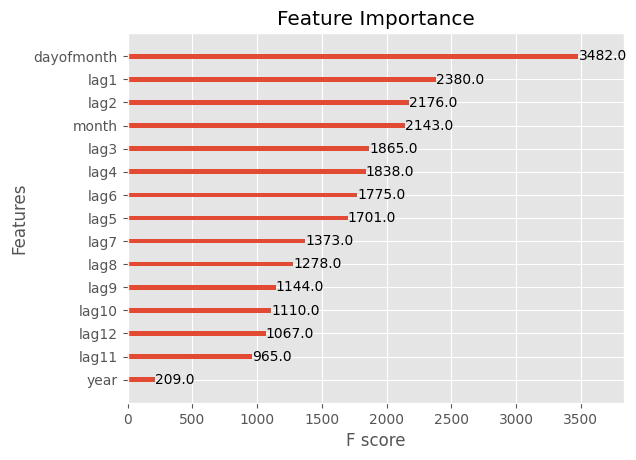

In [ ]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

## Predict In The Future

In [ ]:
start = datetime.datetime.strptime('2024-02-23', "%Y-%m-%d")
end = start + pd.Timedelta(days=num_days_pred)

In [ ]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(future, columns=['formatted_date'])
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features_idx(future_df)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
test_df = pd.read_csv("etf_prices_test_2010-2024.csv")
test_df = test_df[test_df['ETF'] == 'SPY']
test_df.drop(columns=['open', 'high', 'low', 'adjclose', 'volume', 'delta_price', 'direction', 'ETF'],inplace=True)
dates = test_df['formatted_date']
test_df = create_features(test_df)
test_df = add_lags(test_df)

In [ ]:
test_df['pred'] = xgb_best.predict(test_df.drop(columns=['close']))

In [ ]:
prediction_xgb = pd.DataFrame(test_df['pred'])
prediction_xgb.set_index(dates, inplace=True)
prediction_xgb

,pred
formatted_date,
2024-02-26,138.015167
2024-03-04,142.315567
2024-03-11,143.235397
2024-03-18,142.064728
2024-03-25,141.397217
2024-04-01,144.241882


# Prophet

In [25]:
df_prophet = stock_data.copy()

Split

In [26]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

Preprocess

In [27]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'formatted_date':'ds',
                     'close':'y'})

In [28]:
train_prophet

,index,y,ds
0,0,114.190002,2010-01-01
1,1,114.930000,2010-01-08
2,2,111.699997,2010-01-15
3,3,108.570000,2010-01-22
4,4,106.440002,2010-01-29
...,...,...,...
587,587,408.519989,2021-04-02
588,588,415.869995,2021-04-09
589,589,412.269989,2021-04-16
590,590,420.059998,2021-04-23


Training

In [29]:
prophet = Prophet()
prophet.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfyqh9d3/uhlfzmcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmfyqh9d3/8sg0erty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93593', 'data', 'file=/tmp/tmpmfyqh9d3/uhlfzmcb.json', 'init=/tmp/tmpmfyqh9d3/8sg0erty.json', 'output', 'file=/tmp/tmpmfyqh9d3/prophet_modelheyrhref/prophet_model-20240429215452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
# Format data for prophet model using ds and y
test_prophet = test.reset_index() \
    .rename(columns={'formatted_date':'ds',
                     'close':'y'})
test_predict = prophet.predict(test_prophet)

Evaluating

In [31]:
porphet_loss = mean_absolute_percentage_error(test['close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['close'],test_predict['yhat'] ) }% ")

ERROR PERCENT = 9.55884182772783% 


In [32]:
print(f"RMSE: {math.sqrt(sklearn.metrics.mean_squared_error(test['close'], test_predict['yhat']))}")

RMSE: 44.59282325231163


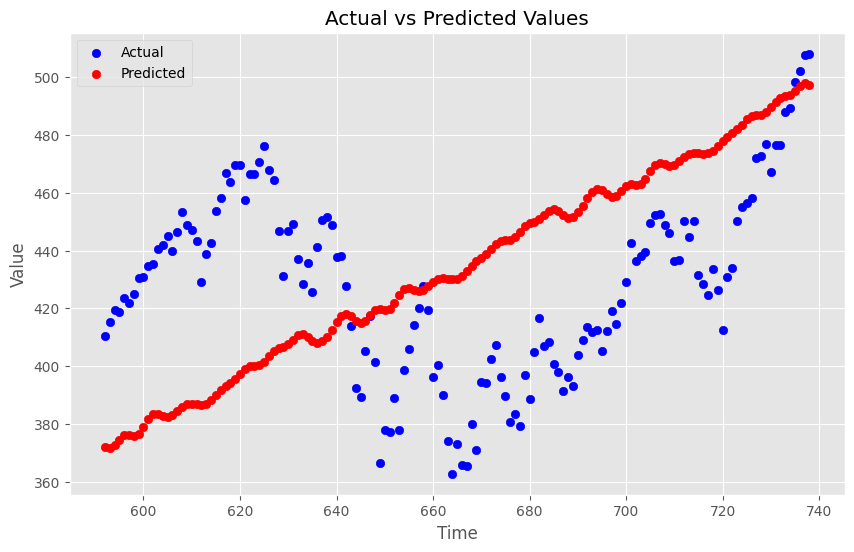

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

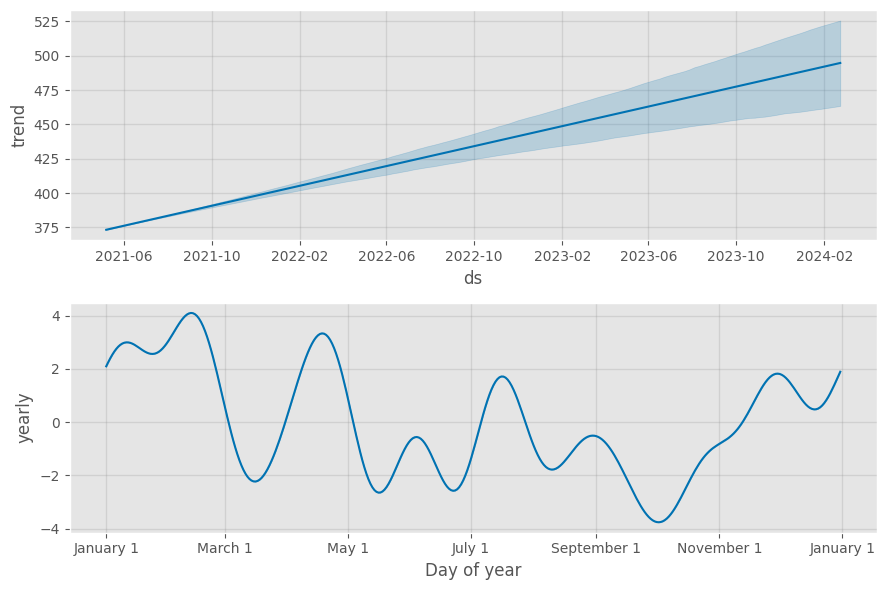

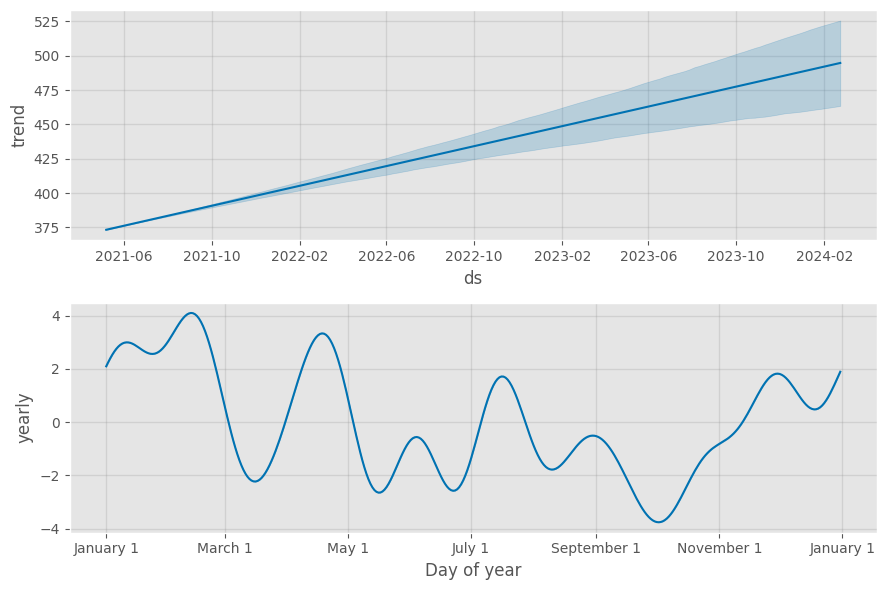

In [ ]:
prophet.plot_components(test_predict)

Predicting in the Future

In [ ]:
prophet_data = df_prophet.reset_index() \
    .rename(columns={'formatted_date':'ds',
                     'close':'y'})
prophet = Prophet()
prophet.fit(prophet_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkgw7dft0/siutj4ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkgw7dft0/i4t6vj_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28138', 'data', 'file=/tmp/tmpkgw7dft0/siutj4ti.json', 'init=/tmp/tmpkgw7dft0/i4t6vj_6.json', 'output', 'file=/tmp/tmpkgw7dft0/prophet_modela803bbjo/prophet_model-20240428152845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet.make_future_dataframe(periods=6, freq='d', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds','yhat']]
forecast_prophet.index = dates

In [ ]:
forecast_prophet

,ds,yhat
formatted_date,,
2024-02-26,2024-02-24,445.839880
2024-03-04,2024-02-25,445.336262
2024-03-11,2024-02-26,444.831489
2024-03-18,2024-02-27,444.331201
2024-03-25,2024-02-28,443.840934
2024-04-01,2024-02-29,443.366034


# ARIMA

In [5]:
df_arima = stock_data.copy()

Split

In [6]:
split_date = df_arima.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

hyperparamter tuning

In [7]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(train_arima['close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3611.375, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3629.764, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3621.737, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3623.492, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3633.554, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3616.215, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3619.829, Time=1.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3609.662, Time=1.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3610.782, Time=1.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3605.406, Time=3.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3605.001, Time=2.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3603.044, Time=0.85 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3617.740, Time=0.81 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3605.022, Time=1.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

train

In [8]:
arima = ARIMA(train_arima['close'], order=best_order)
arima = arima.fit()

evaluate

In [9]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

In [10]:
pred_arima = arima.predict(start=start,end=end-1)

In [11]:
pred_arima.index = test_arima.index

In [12]:
pred_arima

592    418.829585
593    419.750090
594    418.345576
595    418.750717
596    418.617108
          ...    
734    418.631513
735    418.631513
736    418.631513
737    418.631513
738    418.631513
Name: predicted_mean, Length: 147, dtype: float64

In [13]:
test_arima

,close,formatted_date
592,410.279999,2021-05-07
593,415.279999,2021-05-14
594,419.290009,2021-05-21
595,418.769989,2021-05-28
596,423.609985,2021-06-04
...,...,...
734,489.200012,2024-01-26
735,498.320007,2024-02-02
736,502.010010,2024-02-09
737,507.500000,2024-02-16


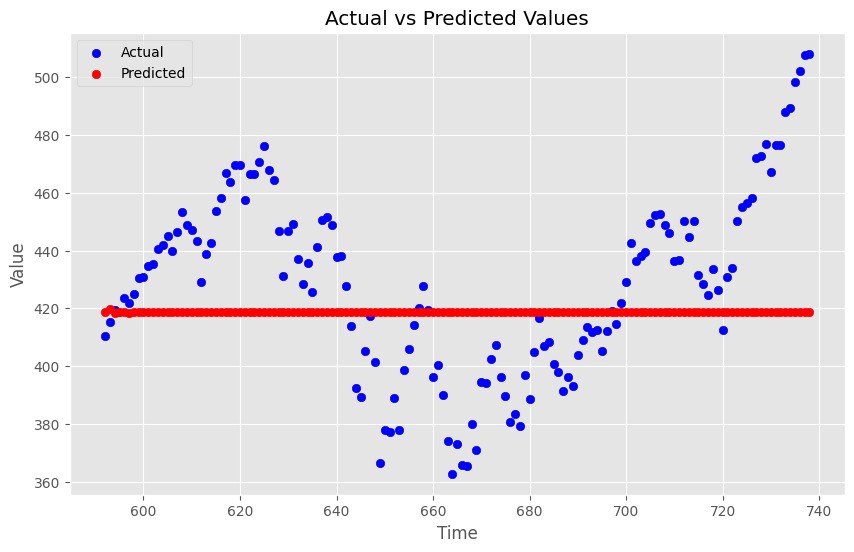

In [ ]:
# pred_arima.plot()
plt.figure(figsize=(10, 6))
plt.scatter(test_arima.index, test_arima['close'], color='blue', label='Actual')
plt.scatter(test_arima.index, pred_arima, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
arima_loss = mean_absolute_percentage_error(test_arima['close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['close'],pred_arima ) }% ")

ERROR PERCENT = 6.2445815265520315% 


In [24]:
import sklearn
import math

print(f"RMSE: {math.sqrt(sklearn.metrics.mean_squared_error(test_arima['close'], pred_arima))}")

RMSE: 33.050578779938256


predict into future

In [ ]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(df_arima['close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4807.379, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4811.961, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4810.210, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4810.724, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4815.261, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4808.866, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4809.675, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4809.378, Time=1.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4806.500, Time=1.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4805.025, Time=1.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4808.370, Time=0.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4803.911, Time=2.71 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4806.364, Time=1.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4802.413, Time=2.71 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

In [ ]:
start = len(df_arima)
end = len(df_arima) + 5
arima_forecast = arima.predict(start=start,end=end)

In [ ]:
# start = df_arima.index.max()
# end = start + pd.Timedelta(days=num_days_pred)
# arima_forecast.index = pd.date_range(start, end, freq='1d')

In [ ]:
arima_forecast = pd.DataFrame(arima_forecast)
arima_forecast.set_index(dates, inplace=True)
arima_forecast

,predicted_mean
formatted_date,
2024-02-26,507.734562
2024-03-04,506.841138
2024-03-11,506.201103
2024-03-18,505.565127
2024-03-25,505.292390
2024-04-01,504.923864


# Communicate the results

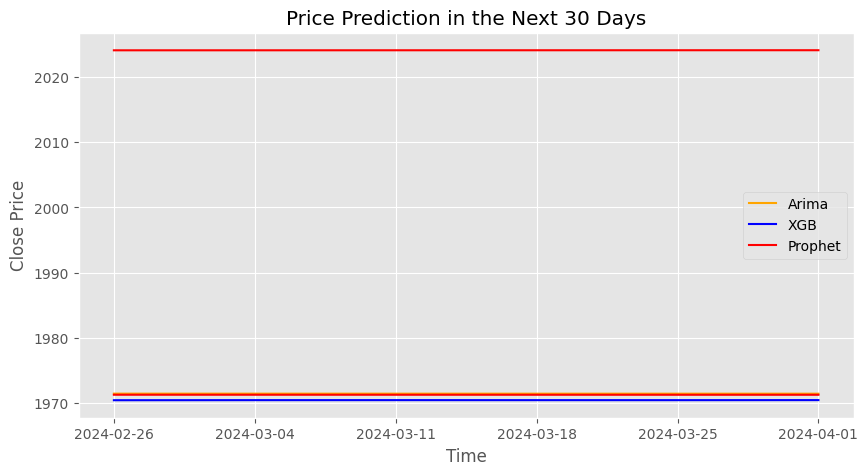

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
forecast_prophet.plot(color = 'red',ax=ax)
plt.legend(['Arima','XGB','Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [ ]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}\nProphet Acc : {100- porphet_loss}")

XGB Acc : 98.10879091184924 
Arima Acc : 93.75541847344797
Prophet Acc : 90.44115817227217
